In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import keras

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import os
import random
import tensorflow as tf

In [ ]:
labels = ['astilbe', 'bellflower','black_eyed_susan','calendula','california_poppy','carnation','common_daisy','coreopsis','daffodil','dandelion','iris','magnolia','rose','sunflower','tulip','water_lily']
img_size = 224
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
data = get_data("/content/drive/MyDrive/RESEARCH INTERN DATASET/flowers")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


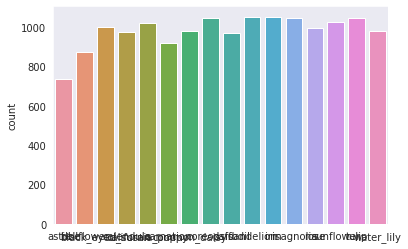

In [ ]:
l = []
for i in data:
    l.append(labels[i[1]])
sns.set_style('dark')
sns.countplot(l)

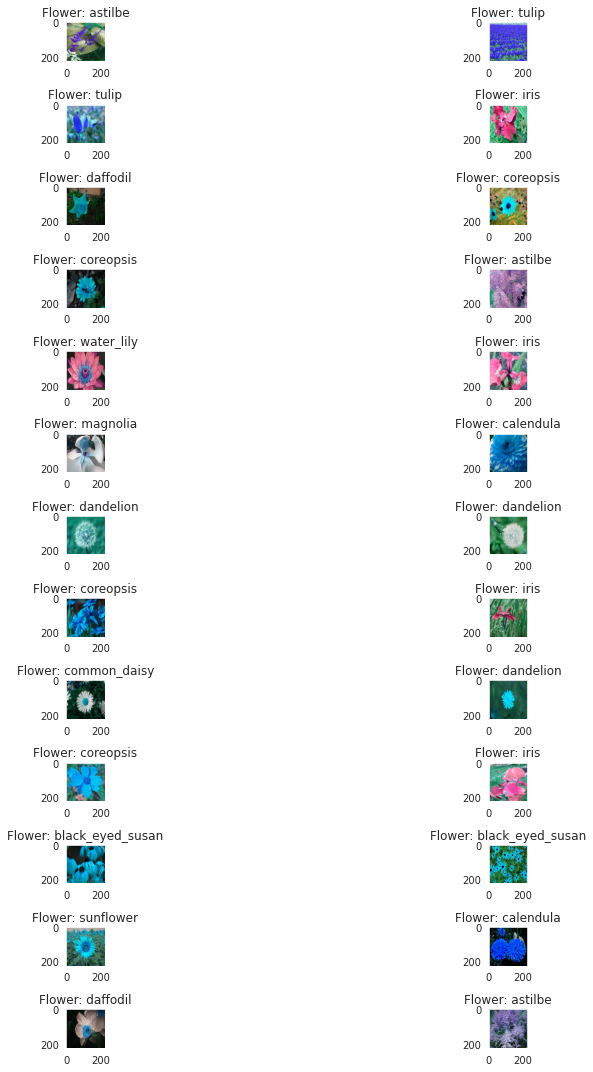

In [ ]:
fig,ax=plt.subplots(13,2)
fig.set_size_inches(15,15)
for i in range(13):
    for j in range (2):
        l=random.randint(0,len(data))
        ax[i,j].imshow(data[l][0])
        ax[i,j].set_title('Flower: '+labels[data[l][1]])

plt.tight_layout()

In [ ]:
x = []
y = []

for feature, label in data:
    x.append(feature)
    y.append(label)

In [ ]:
print(x[0:5])

[array([[[ 13,  29,  11],
        [ 27,  34,  24],
        [ 40,  31,  35],
        ...,
        [ 16,  18,  18],
        [ 17,  19,  19],
        [ 17,  19,  19]],

       [[ 19,  39,  18],
        [ 38,  47,  35],
        [ 39,  35,  34],
        ...,
        [ 18,  20,  20],
        [ 18,  20,  20],
        [ 19,  21,  21]],

       [[ 34,  58,  33],
        [ 50,  65,  47],
        [ 39,  42,  35],
        ...,
        [ 18,  20,  20],
        [ 18,  21,  21],
        [ 20,  21,  21]],

       ...,

       [[ 44, 124,  81],
        [ 20,  95,  53],
        [ 12,  79,  38],
        ...,
        [ 27,  64,  32],
        [ 25,  63,  29],
        [ 20,  58,  23]],

       [[ 53, 102,  64],
        [ 11,  63,  25],
        [  1,  54,  14],
        ...,
        [ 21,  65,  31],
        [ 18,  62,  27],
        [ 16,  60,  24]],

       [[ 48,  76,  42],
        [ 12,  48,  12],
        [  5,  50,  12],
        ...,
        [ 15,  63,  27],
        [ 14,  62,  26],
        [ 17,  64,  28]

In [ ]:
x=np.array(x)

In [ ]:
x = x.reshape(-1, img_size, img_size, 3)
y = np.array(y)


In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x , y , test_size = 0.2 , stratify = y , random_state = 0)

In [ ]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [ ]:
from tensorflow.keras import applications
with strategy.scope():
    pre_trained_model = applications.VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:19]:
        layer.trainable = False

    model = Sequential([
        pre_trained_model,
        MaxPool2D((2,2) , strides = 2),
        Flatten(),
        Dense(16 , activation='softmax')])
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) , loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False) , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 512)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_1 (Dense)             (None, 16)                73744     
                                                                 
Total params: 20,098,128
Trainable params: 4,793,360
Non-trainable params: 15,304,768
_________________________________________________________________


In [ ]:
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
my_generator_train = ImageDataGenerator(rescale=1./255)
my_generator_test=ImageDataGenerator(rescale=1./255)
my_generator_val=ImageDataGenerator(rescale=1./255)

In [ ]:
my_generator_train=my_generator_train.flow_from_directory('/content/drive/MyDrive/RESEARCH INTERN DATASET/dataset/train',target_size=(224,224),batch_size=32)
my_generator_test=my_generator_test.flow_from_directory('/content/drive/MyDrive/RESEARCH INTERN DATASET/dataset/test',target_size=(224,224),batch_size=32,shuffle=False)
my_generator_val=my_generator_val.flow_from_directory('/content/drive/MyDrive/RESEARCH INTERN DATASET/dataset/val',target_size=(224,224),batch_size=32)

Found 12586 images belonging to 16 classes.
Found 1587 images belonging to 16 classes.
Found 1567 images belonging to 16 classes.


In [ ]:
model_path='/content/drive/MyDrive/RESEARCH INTERN DATASET/model_test.h5'
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        #CSVLogger(csv_path),
        #TensorBoard(),
        #EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=False),
    ]


In [ ]:
history = model.fit_generator(my_generator_train,  epochs = 20, validation_data=my_generator_val,callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/20
394/394 [==============================] - ETA: 0s - loss: 0.8980 - accuracy: 0.7248
Epoch 1: val_loss improved from inf to 0.56194, saving model to /content/drive/MyDrive/RESEARCH INTERN DATASET/model_test.h5
394/394 [==============================] - 3100s 8s/step - loss: 0.8980 - accuracy: 0.7248 - val_loss: 0.5619 - val_accuracy: 0.8168 - lr: 1.0000e-04
Epoch 2/20
394/394 [==============================] - ETA: 0s - loss: 0.2897 - accuracy: 0.9134
Epoch 2: val_loss improved from 0.56194 to 0.43353, saving model to /content/drive/MyDrive/RESEARCH INTERN DATASET/model_test.h5
394/394 [==============================] - 92s 234ms/step - loss: 0.2897 - accuracy: 0.9134 - val_loss: 0.4335 - val_accuracy: 0.8602 - lr: 1.0000e-04
Epoch 3/20
394/394 [==============================] - ETA: 0s - loss: 0.1347 - accuracy: 0.9635
Epoch 3: val_loss improved from 0.43353 to 0.41072, saving model to /content/drive/MyDrive/RESEARCH INTERN DATASET/model_test.h5
394/394 [===================

In [ ]:
predictions = model.predict(my_generator_test)

In [ ]:
predictions=np.argmax(predictions,axis=1)

In [ ]:
predictions

array([ 0,  0,  0, ..., 15, 15, 15])

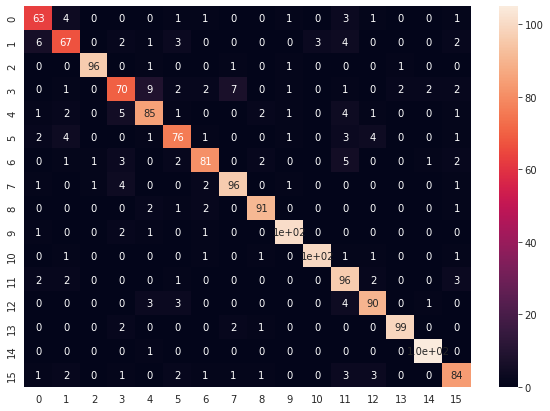

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_true=my_generator_test.classes,y_pred=predictions)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)


In [ ]:
np.sum(np.diag(cm))/np.sum(cm)

0.8367989918084436

In [ ]:
np.sum(np.diag(cm))/np.sum(cm)

0.8821676118462508

In [ ]:
images=my_generator_test.next()

In [ ]:
img=images[0]
lab=images[1]

In [ ]:
np.argmax(model.predict(img[0].reshape(-1,224,224,3)),axis=1)

array([0])

In [ ]:
np.argmax(lab[0])

0

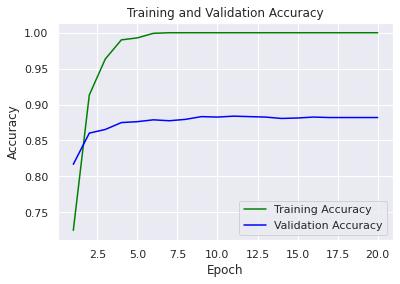

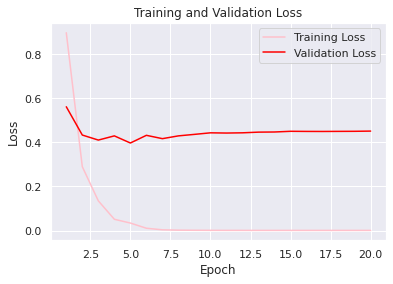

In [ ]:
#plotting training values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from sklearn.metrics import  classification_report

In [ ]:
Y_pred = model.predict(val_generator)
model.evaluate(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, y_pred))
print('Classification Report')
target_names = ['astilbe','bellflower','black_eyed_susan','calendula','california_poppy','carnation','common_daisy','coreopsis','daffodil',
                'dandelion','iris','magnolia','rose','sunflower','tulip','water_lily']
print(classification_report(val_generator.classes, y_pred, target_names=target_names))
plt.figure(figsize=(10,8))
plt.title('Predicted classes', size=14)
sns.heatmap(confusion_matrix(val_generator.classes, y_pred), annot=True, fmt = '.0f',linewidths=.5)
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
precision_recall_fscore_support(my_generator_test.classes, predictions, average='macro')

(0.8803267514905426, 0.8790729091852503, 0.8791135490995168, None)